<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from pyAgrum.lib._utils.oslike import head

import os
#the bases will be saved in "out/*.csv"
EMnomissing="out/EM_nomissing.csv"
EMmissing="out/EM_missing.csv"

### generating data with missing values (at random)

In [2]:
src=gum.fastBN("A->B<-C->D->E<-B;D->F")
gum.generateCSV(src,EMnomissing,5000,random_order=False)
src

(gum::BayesNet<double>@0000021DFE7B6570) BN{nodes: 6, arcs: 6, domainSize: 64, dim: 28}

In [3]:
import pandas as pd
import numpy as np

def add_missing(src,dst,proba):
  df=pd.read_csv(src)
  mask=np.random.choice([True, False], size=df.shape,p=[proba,1-proba])
  df.mask(mask).to_csv(dst,na_rep='?',index=False,float_format='%.0f')

gum.generateCSV(src,EMnomissing,5000,random_order=False)
add_missing(EMnomissing,EMmissing,proba=0.1)

In [4]:
print("No missing")
head(EMnomissing)
print("Missing")
head(EMmissing)

No missing
A,B,C,D,E,F
1,1,1,1,1,0
0,0,1,1,0,1
0,0,1,1,0,0
0,1,1,1,1,1
1,0,1,1,1,1
1,1,1,1,1,0
1,0,1,1,0,0
1,1,1,1,1,0
1,1,1,1,1,1

Missing
A,B,C,D,E,F
1,1,1,?,1,0
0,0,1,1,0,1
0,0,1,1,0,0
0,1,1,1,1,1
1,0,1,1,1,1
?,1,1,1,1,0
1,0,1,1,0,0
1,1,1,1,1,0
1,1,1,1,1,1



### learning with missing data

In [5]:
learner = gum.BNLearner(EMmissing, ["?"])
print(f"Missing values in {EMmissing} : {learner.hasMissingValues()}")

Missing values in out/EM_missing.csv : True


In [6]:
# this will fail : missing data !
# learner.learnParameters(src.dag())

In [10]:
learner.useEM(1e-3)
learner.useAprioriSmoothing()
bn=learner.learnParameters(src.dag())
print(f"# iterations : {learner.nbrIterations()}")
gnb.flow.row(gnb.getInference(src),gnb.getInference(bn))

# iterations : 7


### learning with smaller error (and no smoothing)

In [11]:
learner = gum.BNLearner(EMmissing, ["?"])
learner.setVerbosity(True)
learner.useEM(1e-8)
bn2=learner.learnParameters(src.dag())
gnb.flow.row(gnb.getInference(src),gnb.getInference(bn2),captions=["Source",f"Estimation EM en {learner.nbrIterations()} iteration(s)"])

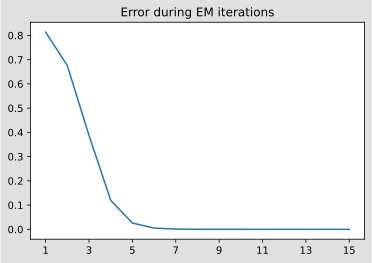

In [12]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(1,1+learner.nbrIterations()),learner.history())
plt.xticks(np.arange(1, 1+learner.nbrIterations(), step=2))
plt.title("Error during EM iterations");